In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import datetime
import platform

from pathlib import Path
from os.path import expanduser
from os import path, getcwd
import logging

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn_evaluation import plot as sk_plot

import yass
from yass import read_config, preprocess, detect
from yass import util
from yass.augment import make
from yass.neuralnetwork import NeuralNetDetector, NeuralNetTriage, AutoEncoder 
from yass.explore import RecordingExplorer, SpikeTrainExplorer
from yass.augment.noise import noise_cov
from yass.templates import TemplatesProcessor
from yass.augment.util import amplitudes

import numpy as np
from scipy.io import loadmat

from dstools import plot, Env
from dstools.reproducibility import make_filename
from dstools.reproducibility.util import get_version, git_hash_in_path
from dstools.util import save

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from sklearn.model_selection import train_test_split

# logging.basicConfig(level=logging.DEBUG)

In [6]:
here = getcwd()
here_version = git_hash_in_path(here)

In [7]:
# for reference
print('YASS version is: {}'.format(util.get_version()))
print('nbs version is: {}'.format(here_version))

YASS version is: 0b2e923 fix
nbs version is: a786da4 Merge branch 'master' of https://github.com/edublancas/yass-private


In [8]:
path_to_data = path.expanduser('~/data')
path_to_ground_truth = path.join(path_to_data,
                                 'retinal/groundtruth_ej49_data1_set1.mat')
path_to_experiment = path.join(path_to_data, 'retinal/sample_output')
path_to_standarized = path.join(path_to_experiment,
                                'preprocess', 'standarized.bin')
path_to_geom = path.join(path_to_data, 'retinal/ej49_geometry1.txt')
path_to_here = path.expanduser('~/dev/private-yass/nnet')

In [9]:
yass.set_config("config/gcloud/49/default.yaml", 'tmp')
CONFIG = read_config()

In [10]:
raw_templates = np.load(Path(path_to_data, 'cat/templates-jul27-only-good.npy'))
n_templates, waveform_length, _ = raw_templates.shape
print(raw_templates.shape)

(240, 61, 49)


In [11]:
# crop spatially
processor = TemplatesProcessor(raw_templates)
templates = (processor
            .crop_spatially(CONFIG.neigh_channels, CONFIG.geom)
            .values)
templates.shape

(240, 61, 7)

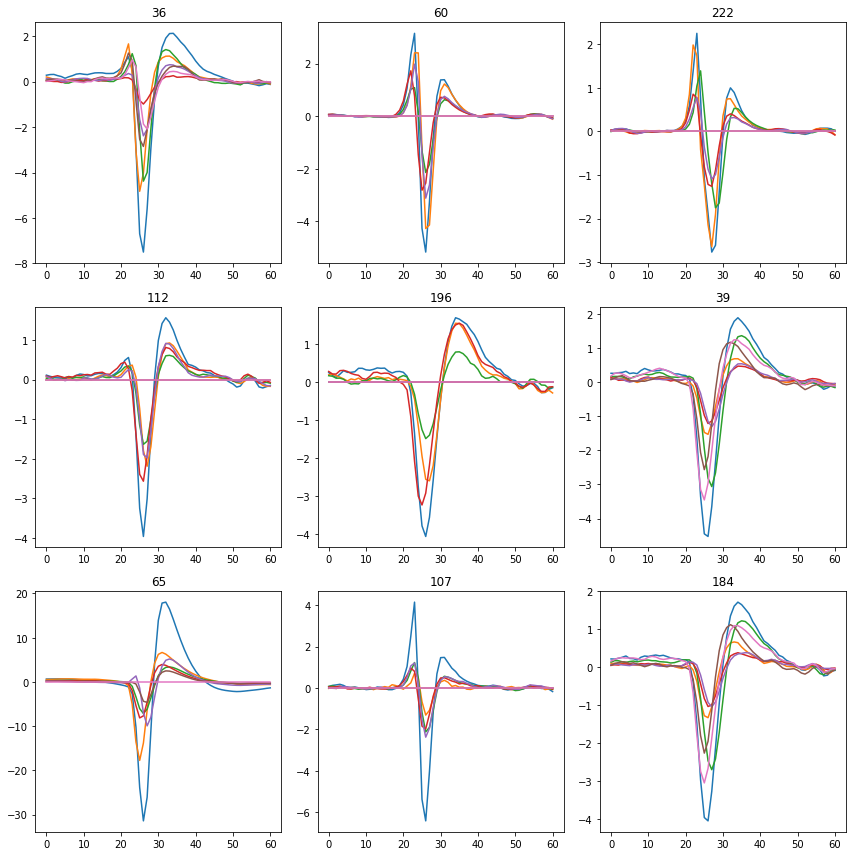

In [12]:
plot.grid_from_array(templates, axis=0, auto_figsize=4,
                     max_cols=3, elements=9)

In [13]:
from yass.augment import util

In [14]:
min_amplitude = 4
max_amplitude = 45
n_per_template = 10

x = util.make_from_templates(templates,
                             min_amplitude=min_amplitude,
                             max_amplitude=max_amplitude,
                             n_per_template=n_per_template)

In [15]:
# add to tests
assert util.amplitudes(x).min() == min_amplitude
assert util.amplitudes(x).max() == max_amplitude
assert x.shape[0] == templates.shape[0] * n_per_template

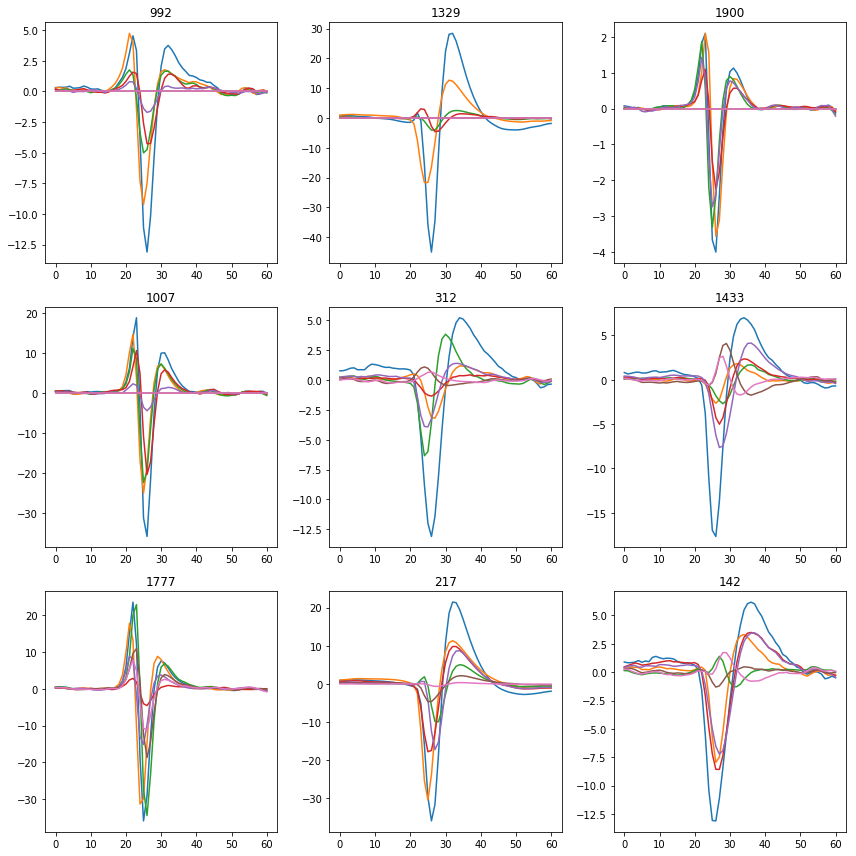

In [17]:
plot.grid_from_array(x, axis=0, auto_figsize=4,
                     max_cols=3, elements=9)

In [40]:
n_per_spike = 1
multi_channel = True
min_shift = 5

sp = util.make_spatially_misaligned(x, n_per_spike=1,
                                    force_first_channel_shuffle=False)

collided = util.make_collided(x, sp, n_per_spike, min_shift,
                              amp_tolerance=0.2, max_shift='auto', return_metadata=False)

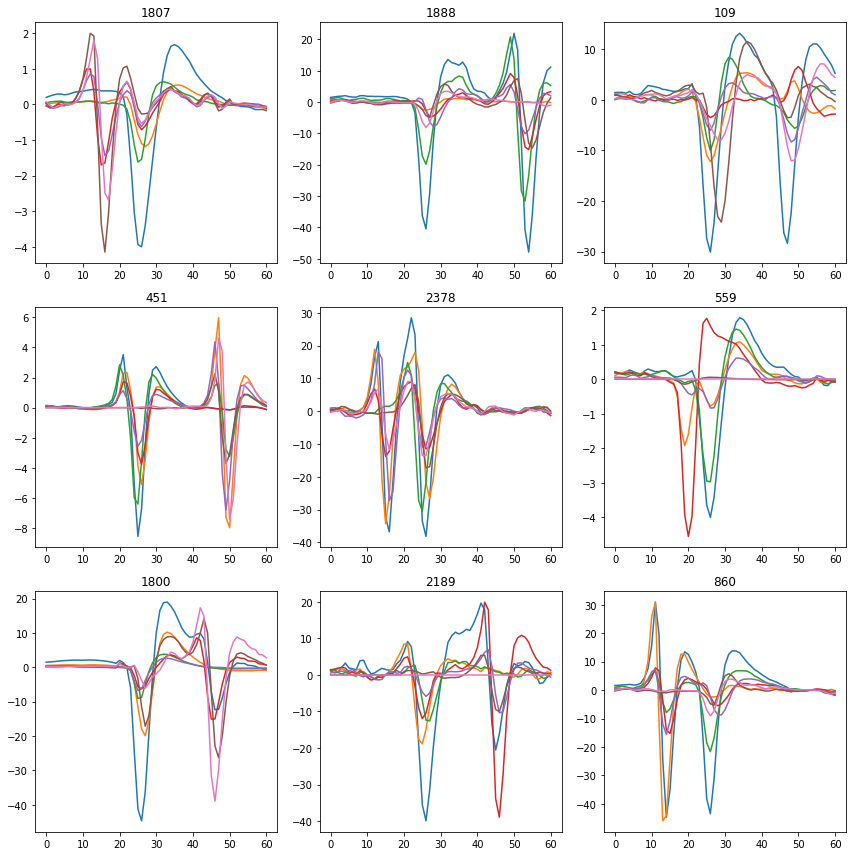

In [41]:
plot.grid_from_array(collided, axis=0, auto_figsize=4,
                     max_cols=3, elements=9)

In [42]:
n_per_spike = n_per_spike

spatial = util.make_spatially_misaligned(x, n_per_spike=n_per_spike,
                                         force_first_channel_shuffle=True)

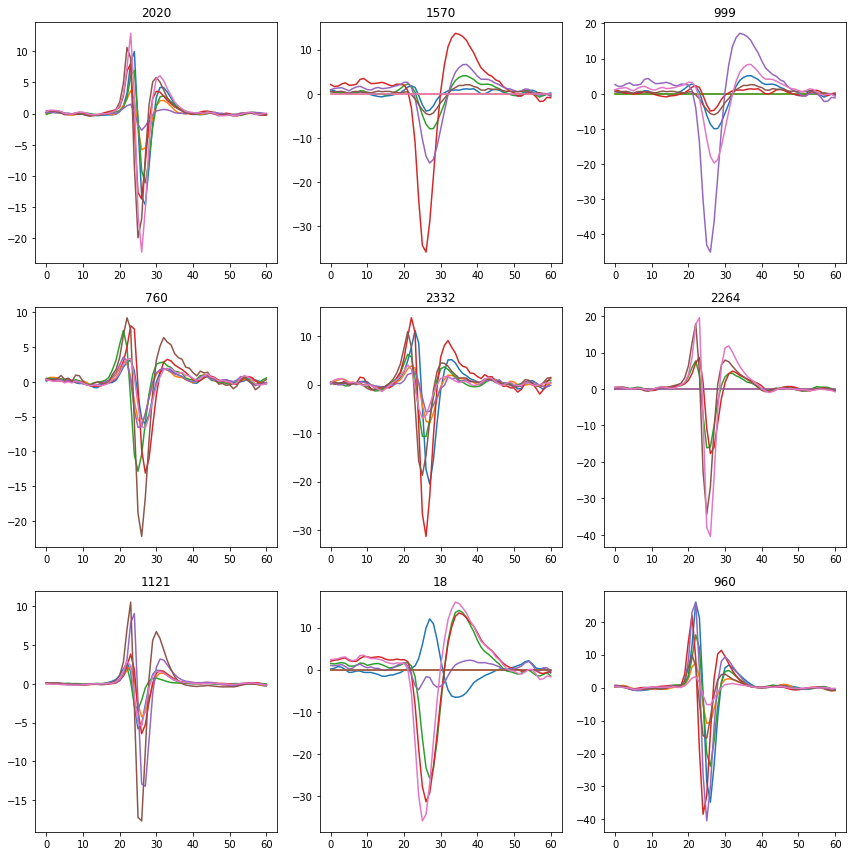

In [43]:
plot.grid_from_array(spatial, axis=0, auto_figsize=4,
                     max_cols=3, elements=9)

In [46]:
n_per_spike = 1
min_shift = 'auto'
max_shift = 'auto'

temporal = util.make_temporally_misaligned(x, n_per_spike=n_per_spike,
                                      min_shift=min_shift,
                                        max_shift=max_shift)

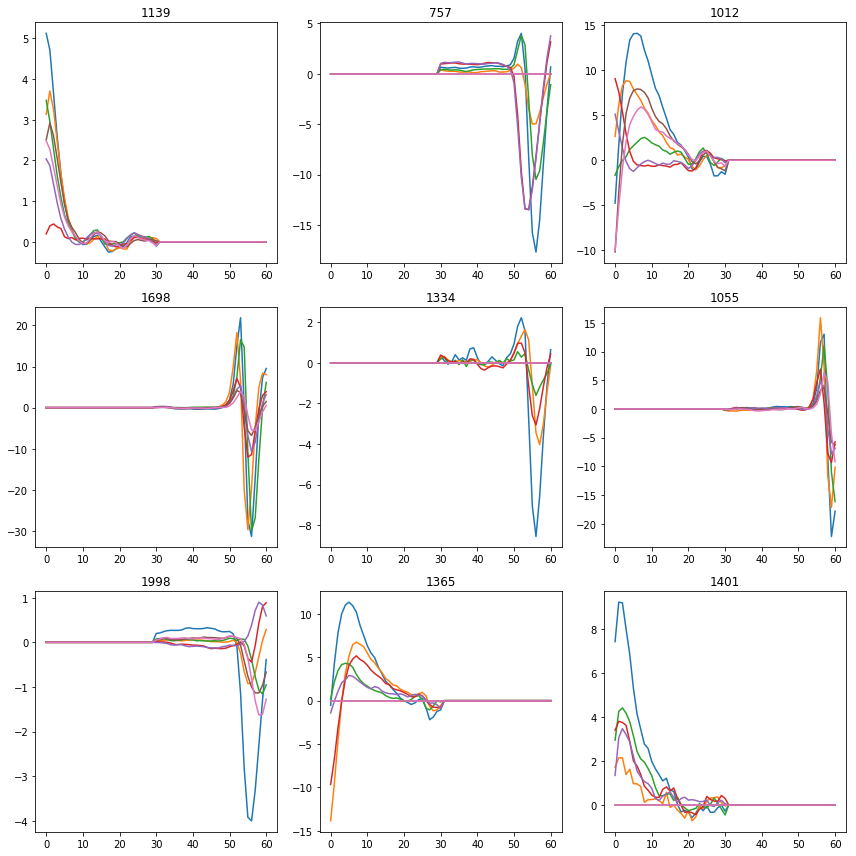

In [47]:
plot.grid_from_array(temporal, axis=0, auto_figsize=4,
                     max_cols=3, elements=9)